# COVID-19 Progress Graphs

There's a ton of graphs and information about COVID-19 going around, but when dealing with the numbers, it can be hard to pick out what it all means. Essentially, the virus has exponential growth, and it can seem to creep up really fast—Italy has been hit really hard, but the numbers feel surreal and foreign. I decided to explore the numbers for myself, and this is the result of that. I make no guarantees about the data, and I encourage you to explore it yourself. Feel free to use this as a starting point if you wish. At the end I specifically investigate the numbers in Canada and specifically Alberta—my home.

The data comes from Johns Hopkins University, which is published at https://github.com/CSSEGISandData/COVID-19 and is up to date as of 2020-03-17. Specifically, the data comes from the `time_series_19-covid-Confirmed.csv` file. Population data came from https://www.worldometers.info/population/ and Wikipedia where _worldometer_ didn't have data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['figure.figsize'] = (8.5, 4)
plt.rcParams['figure.dpi'] = 150

In [2]:
cases = pd.read_csv('time_series_19-covid-Confirmed.csv')
cases.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
463,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
464,NaN,Chad,15.4542,18.7322,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
465,NaN,El Salvador,13.7942,-88.8965,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
466,NaN,Fiji,-17.7134,178.0650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
467,NaN,Nicaragua,12.8654,-85.2072,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## The World

In [3]:
countries = ['Canada', 'Italy', 'US', 'France', 'Spain', 'Germany', 'United Kingdom', 'Sweden', 'South Korea', 'Thailand', 'Iran']

In [4]:
timeline = pd.DataFrame()
for country in countries:
    countryCases = pd.DataFrame(data=cases[cases['Country/Region'] == country].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).sum(axis=0), columns=[country])
    timeline = timeline.join(countryCases, how='outer')
timeline.index = pd.to_datetime(timeline.index)
timeline.tail()

,Canada,Italy,US,France,Spain,Germany,United Kingdom,Sweden,South Korea,Thailand,Iran
2020-03-15,252,24747,3499,4523,7798,5795,1145,1022,0,114,13938
2020-03-16,415,27980,4632,6668,9942,7272,1551,1103,0,147,14991
2020-03-17,478,31506,6421,7699,11748,9257,1960,1190,0,177,16169
2020-03-18,657,35713,7783,9105,13910,12327,2642,1279,0,212,17361
2020-03-19,800,41035,13677,10947,17963,15320,2716,1439,0,272,18407


First, a plot of the COVID-19 confirmed cases in a few select countries. Note that this is the total, and does not take into account population sizes of each country. For most countries, the case numbers remain low until they suddenly take off at some point and then all exhibit similar growth. The exception to this (in this list of countries) is Thailand.

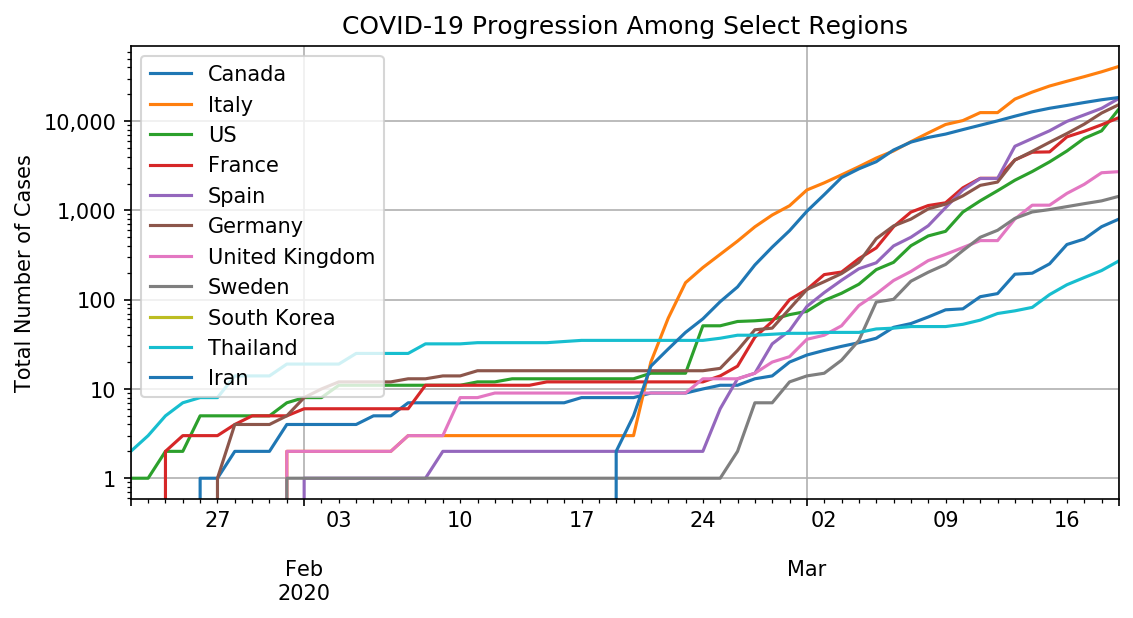

In [5]:
ax = timeline.plot()
plt.yscale('log')
plt.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('COVID-19 Progression Among Select Regions')
plt.ylabel('Total Number of Cases')
plt.show()

Total cases can be a bit deceiving when you're comparing countries with vastly different population sizes, so for the remaining analysis I normalize the confirmed case load by the population of the country / region, such that all numbers are reported per 1 million people.

In [6]:
population = pd.DataFrame(data={
    'China': 1437_677_020,
    'South Korea': 51_256_189,
    'Italy': 60_487_893,
    'United Kingdom': 67_780_066,
    'US': 330_425_304,
    'Germany': 83_704_671,
    'Spain': 46_749_449,
    'Canada': 37_643_160,
    'Alberta': 4_395_586,
    'France': 65_273_511,
    'Thailand': 69_799_978,
    'Sweden': 10_099_265,
    'Iran': 83_992_949,
}, index=['Population'])
population

,China,South Korea,Italy,United Kingdom,US,Germany,Spain,Canada,Alberta,France,Thailand,Sweden,Iran
Population,1437677020,51256189,60487893,67780066,330425304,83704671,46749449,37643160,4395586,65273511,69799978,10099265,83992949


In [7]:
popTimeline = timeline.copy()
for country in timeline.columns.values:
    popTimeline[country] = timeline[country] / population[country].values[0] * 1000000
popTimeline.tail()

,Canada,Italy,US,France,Spain,Germany,United Kingdom,Sweden,South Korea,Thailand,Iran
2020-03-15,6.694443,409.123194,10.589383,69.293040,166.804105,69.231501,16.892872,101.195483,0.0,1.633238,165.942501
2020-03-16,11.024579,462.571907,14.018297,102.154762,212.665608,86.876872,22.882834,109.215869,0.0,2.106018,178.479267
2020-03-17,12.698190,520.864564,19.432531,117.949837,251.297079,110.591200,28.917057,117.830357,0.0,2.535817,192.504254
2020-03-18,17.453370,590.415672,23.554491,139.489969,297.543614,147.267767,38.979012,126.642879,0.0,3.037250,206.695922
2020-03-19,21.252201,678.400221,41.392108,167.709685,384.239823,183.024434,40.070778,142.485617,0.0,3.896849,219.149348


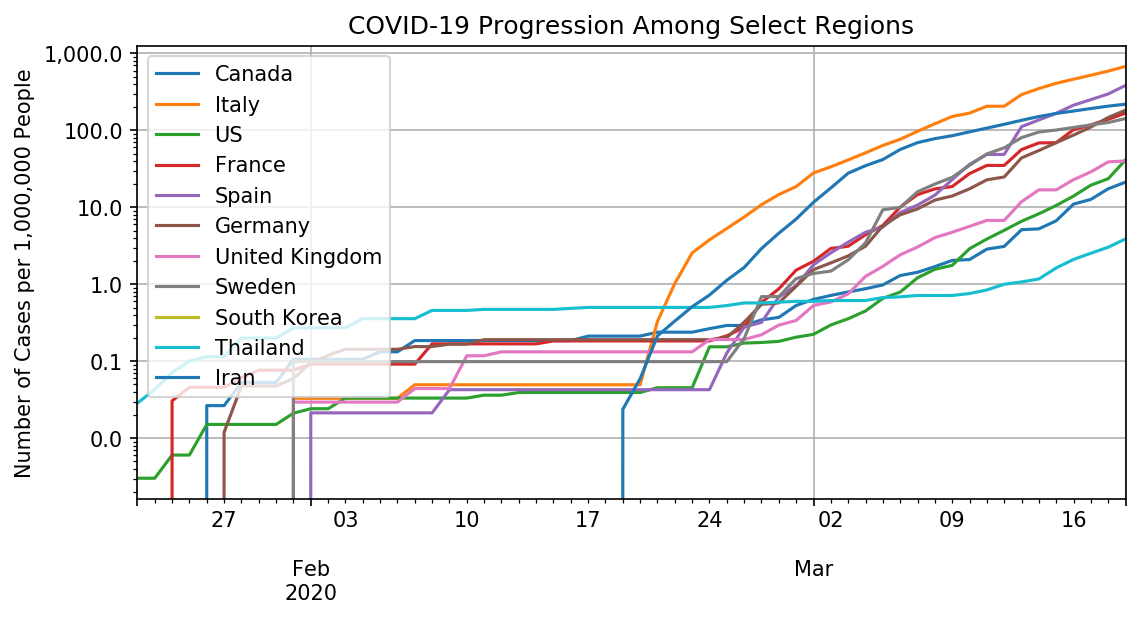

In [8]:
ax = popTimeline.plot()
plt.yscale('log')
plt.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
plt.title('COVID-19 Progression Among Select Regions')
plt.ylabel('Number of Cases per 1,000,000 People')
plt.show()

From basic inspection it looks like the curves above are all pretty similar with the exception that they are offset in time from each other. Spain doesn't look so different from Italy, except that the outbreak there appeared to start roughly 1 week later than in Italy. To investigate this, I “normalize” each country's curve to the point where each country's case load reach 0.3 / 1 million people. This is an arbitrary number, taken from inspection of the above graph.

In [9]:
timing = {}
caseThreshold = 0.3

# first, figure out when they crossed a “magic” threshold
for country in popTimeline.columns.values:
    for i in range(len(popTimeline[country])):
        if popTimeline[country].iloc[i] >= caseThreshold:
            timing[country] = popTimeline.index[i]
            break
timing = pd.DataFrame(data=timing, index=['Start of Outbreak']).transpose()
timing

,Start of Outbreak
Canada,2020-02-27
Italy,2020-02-21
US,2020-03-03
France,2020-02-27
Spain,2020-02-27
Germany,2020-02-26
United Kingdom,2020-02-29
Sweden,2020-02-27
Thailand,2020-02-04
Iran,2020-02-22


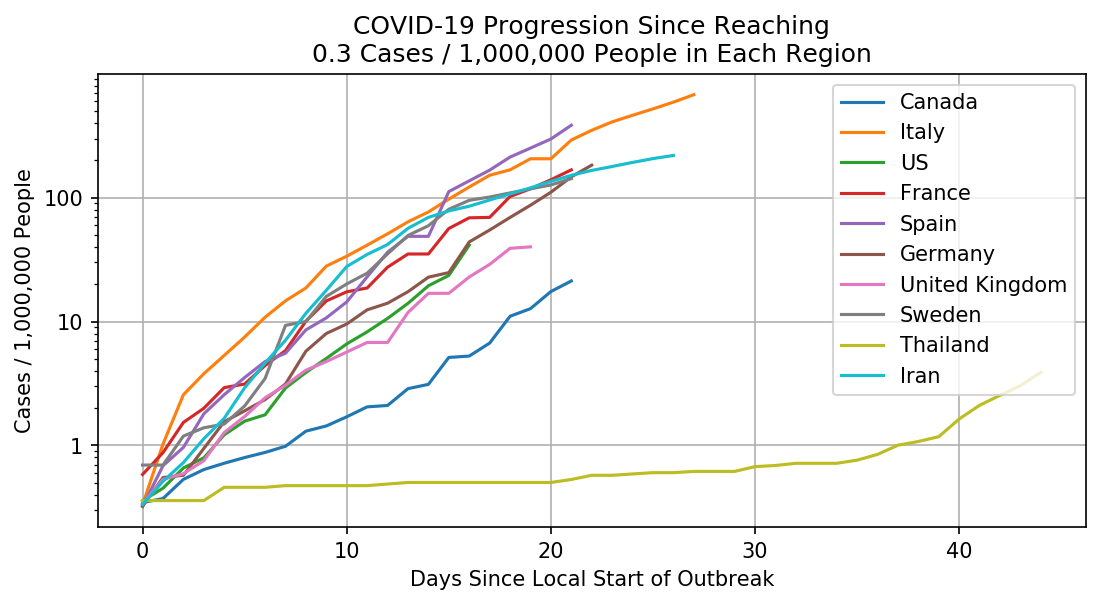

In [10]:
import matplotlib as mpl

fig, ax = plt.subplots()
plt.yscale('log')

for country, row in timing.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popTimeline[country][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    plt.plot(outbreakDays, outbreakCases.values, label=country)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid()
plt.xlabel('Days Since Local Start of Outbreak')
plt.ylabel('Cases / 1,000,000 People')
plt.title('COVID-19 Progression Since Reaching\n%.1f Cases / 1,000,000 People in Each Region' % caseThreshold)
plt.show()

Immediately, it seems that most countries follow the same pattern, with slightly varying rates of infection (the slope of the lines). Thailand is clearly doing extremely well containing and mitigating the virus. Of the examined countries, Canada is doing the next “best”, while Italy has experienced the most aggressive infection rates.

These curves can be used to attempt to estimate the progression of the outbreak in each region by fitting a straight line to each of the logarithmic curves:

In [11]:
outbreakRegression = {
    'slope': [],
    'intercept': [],
    'r2': [],
    'p': [],
    'err': [],
}
for country, row in timing.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popTimeline[country][startDate:]
    
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    logCases = np.log10(outbreakCases.values)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(outbreakDays, y=logCases)
    outbreakRegression['slope'].append(slope)
    outbreakRegression['intercept'].append(intercept)
    outbreakRegression['r2'].append(r_value**2)
    outbreakRegression['p'].append(p_value)
    outbreakRegression['err'].append(std_err)
    
outbreakRegression = pd.DataFrame(data=outbreakRegression, index=timing.index)
outbreakRegression

,slope,intercept,r2,p,err
Canada,0.082242,-0.527738,0.978304,4.112096e-18,0.002739
Italy,0.104611,0.276707,0.941628,1.455495e-17,0.005108
US,0.124779,-0.445972,0.997064,2.068967e-20,0.001748
France,0.114538,-0.036830,0.983562,2.557773e-19,0.003311
Spain,0.142584,-0.244184,0.989062,4.339269e-21,0.003353
Germany,0.122287,-0.352531,0.991524,3.043500e-23,0.002467
United Kingdom,0.108524,-0.363519,0.988536,6.377262e-19,0.002755
Sweden,0.123405,-0.111102,0.955115,5.971460e-15,0.005982
Thailand,0.015579,-0.521518,0.718765,2.021502e-13,0.001486
Iran,0.107475,-0.008287,0.902504,3.815247e-14,0.007065


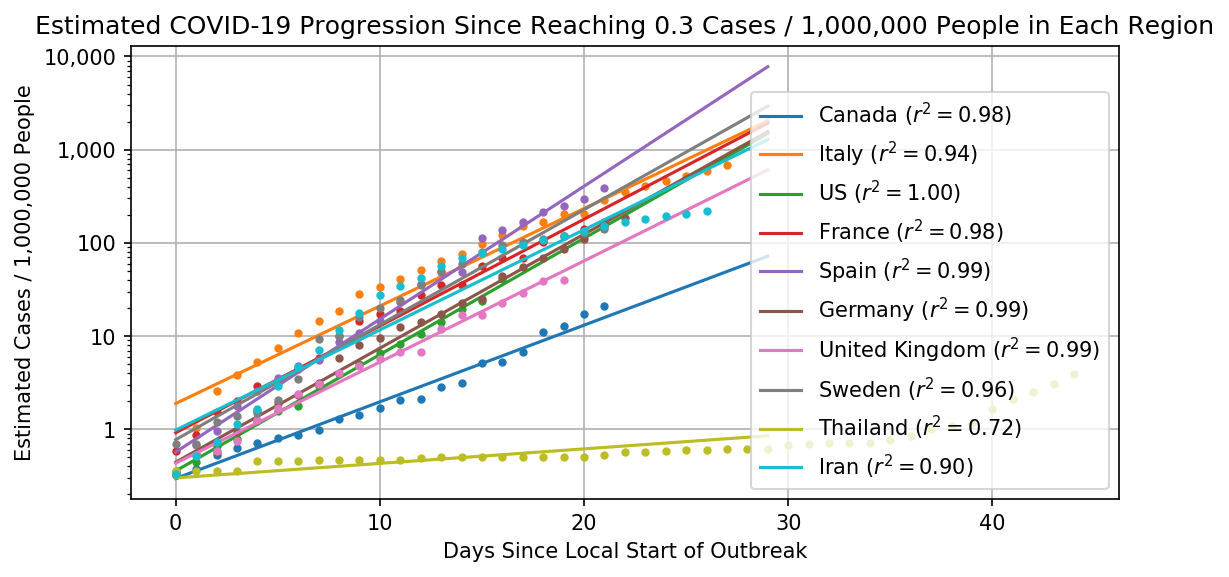

In [12]:
fig, ax = plt.subplots()
plt.yscale('log')

for i, (country, row) in enumerate(timing.iterrows()):
    startDate = row['Start of Outbreak']
    outbreakCases = popTimeline[country][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    plt.plot(outbreakDays, outbreakCases.values, '.C%d' % i, label=None)
    plt.plot(np.power(10, np.polyval([outbreakRegression['slope'][country], outbreakRegression['intercept'][country]], np.arange(0, 30))), label='%s ($r^2=%.2f$)' % (country, outbreakRegression['r2'][country]))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid()
plt.xlabel('Days Since Local Start of Outbreak')
plt.ylabel('Estimated Cases / 1,000,000 People')
plt.title('Estimated COVID-19 Progression Since Reaching %.1f Cases / 1,000,000 People in Each Region' % caseThreshold)
plt.show()

This can be used to estimate how long until each country will reach 1,000 confirmed cases per 1,000,000 population (1 / 1,000 confirmed cases).

In [13]:
estimatedDays = pd.Series((np.log10(1000) - outbreakRegression['intercept']) / outbreakRegression['slope'], name="Estimated Days To Reach 1,000 COVID-19 Cases / 1,000,000 People")
estimatedDays = pd.DataFrame(data=estimatedDays)
estimatedDays.sort_values('Estimated Days To Reach 1,000 COVID-19 Cases / 1,000,000 People', axis=0)

,"Estimated Days To Reach 1,000 COVID-19 Cases / 1,000,000 People"
Spain,22.752778
Sweden,25.210587
Italy,26.032602
France,26.513801
Germany,27.415333
US,27.616525
Iran,27.990529
United Kingdom,30.993451
Canada,42.894598
Thailand,226.044197


This can be coupled with the start date of each infection to roughly estimate when each country will experience 1 case for every 1000 people:

In [14]:
dates = {}
for country, row in timing.iterrows():
    startDate = row['Start of Outbreak']
    if outbreakRegression['slope'][country] == 0:
        continue
    daysTo1In1000 = (np.log10(1_000) - outbreakRegression['intercept'][country]) / outbreakRegression['slope'][country]
    if np.isnan(daysTo1In1000):
        continue
    dates[country] = startDate + np.timedelta64(np.int(daysTo1In1000), 'D')
dates = pd.DataFrame(data=dates, index=['Date of 1/1000 Cases'])
dates

,Canada,Italy,US,France,Spain,Germany,United Kingdom,Sweden,Thailand,Iran
Date of 1/1000 Cases,2020-04-09,2020-03-18,2020-03-30,2020-03-24,2020-03-20,2020-03-24,2020-03-30,2020-03-23,2020-09-17,2020-03-20


Finally, the growth rate and doubling time can be calculated for each country. This is somewhat simplified calculation as it only looks at the current level of infection and doesn't look at how the growth rate has changed over time, but it can be used to compare strategies across countries. The closer to 0 the growth rate is, the better. The longer the doubling time, the better.

In [15]:
growth = {}
for country, row in timing.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popTimeline[country][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    growthRate = np.log(outbreakCases[-1] / outbreakCases[0]) / outbreakDays[-1]
    if growthRate == 0.0:
        continue
    doublingTime = np.log(2) / growthRate
    growth[country] = {}
    growth[country]['Growth Rate'] = growthRate
    growth[country]['Doubling Time (Days)'] = doublingTime
growth = pd.DataFrame(data=growth)
growth

,Canada,Italy,US,France,Spain,Germany,United Kingdom,Sweden,Thailand,Iran
Growth Rate,0.196174,0.282461,0.297049,0.269678,0.337525,0.288231,0.251127,0.253609,0.054248,0.249549
Doubling Time (Days),3.533321,2.453957,2.333443,2.570279,2.053619,2.404834,2.760141,2.733131,12.777301,2.777596


## Canada

With some countries analyzed, my next concern is the provinces in Canada. The exact same analysis as was done for countries can be done for provinces in Canada.

In [16]:
canada = pd.DataFrame(data=cases[cases['Country/Region'] == 'Canada'].drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)).transpose()
canada.columns = cases[cases['Country/Region'] == 'Canada']['Province/State'].values
canada.index = pd.to_datetime(canada.index)
del canada['Grand Princess']
canada.tail()

,British Columbia,Ontario,Alberta,Quebec,New Brunswick,Manitoba,Saskatchewan,Newfoundland and Labrador,Prince Edward Island,Nova Scotia
2020-03-15,73,104,39,24,2,4,2,1,1,0
2020-03-16,103,177,56,50,6,7,7,1,1,5
2020-03-17,103,185,74,74,8,8,7,3,1,7
2020-03-18,186,221,97,94,11,15,8,3,1,12
2020-03-19,231,257,119,121,11,17,16,3,2,14


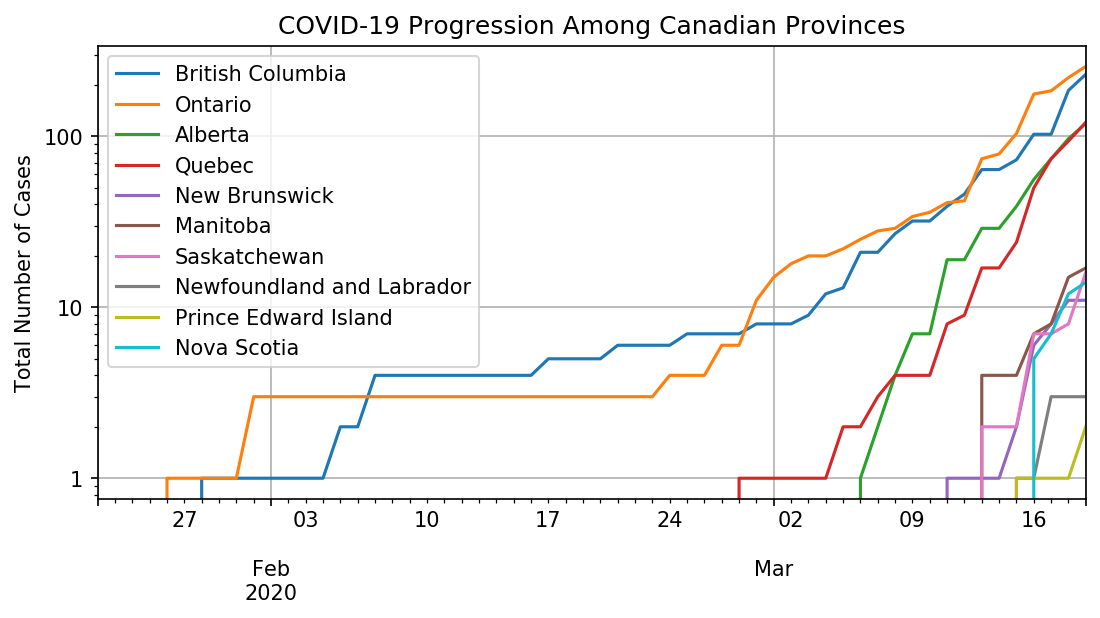

In [17]:
ax = canada.plot()
plt.yscale('log')
plt.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('COVID-19 Progression Among Canadian Provinces')
plt.ylabel('Total Number of Cases')
plt.show()

In [18]:
populationCanada = pd.DataFrame(data={
    'British Columbia': 5_105_576,
    'Ontario': 14_659_616,
    'Alberta': 4_395_586,
    'Quebec': 8_522_800,
    'New Brunswick': 780_021,
    'Manitoba': 1_373_859,
    'Saskatchewan': 1_190_657,
    'Newfoundland and Labrador': 521_922,
    'Prince Edward Island': 157_901,
    'Nova Scotia': 976_768,
}, index=['Population'])
populationCanada

,British Columbia,Ontario,Alberta,Quebec,New Brunswick,Manitoba,Saskatchewan,Newfoundland and Labrador,Prince Edward Island,Nova Scotia
Population,5105576,14659616,4395586,8522800,780021,1373859,1190657,521922,157901,976768


In [19]:
popCanada = canada.copy()
for province in canada.columns.values:
    popCanada[province] = canada[province] / populationCanada[province].values[0] * 1000000
popCanada.tail()

,British Columbia,Ontario,Alberta,Quebec,New Brunswick,Manitoba,Saskatchewan,Newfoundland and Labrador,Prince Edward Island,Nova Scotia
2020-03-15,14.298093,7.094320,8.872537,2.815976,2.564034,2.911507,1.679745,1.915995,6.333082,0.000000
2020-03-16,20.174022,12.073986,12.740053,5.866617,7.692101,5.095137,5.879107,1.915995,6.333082,5.118923
2020-03-17,20.174022,12.619703,16.835070,8.682593,10.256134,5.823014,5.879107,5.747985,6.333082,7.166492
2020-03-18,36.430757,15.075429,22.067592,11.029239,14.102184,10.918151,6.718980,5.747985,6.333082,12.285415
2020-03-19,45.244650,17.531155,27.072613,14.197212,14.102184,12.373904,13.437959,5.747985,12.666164,14.332984


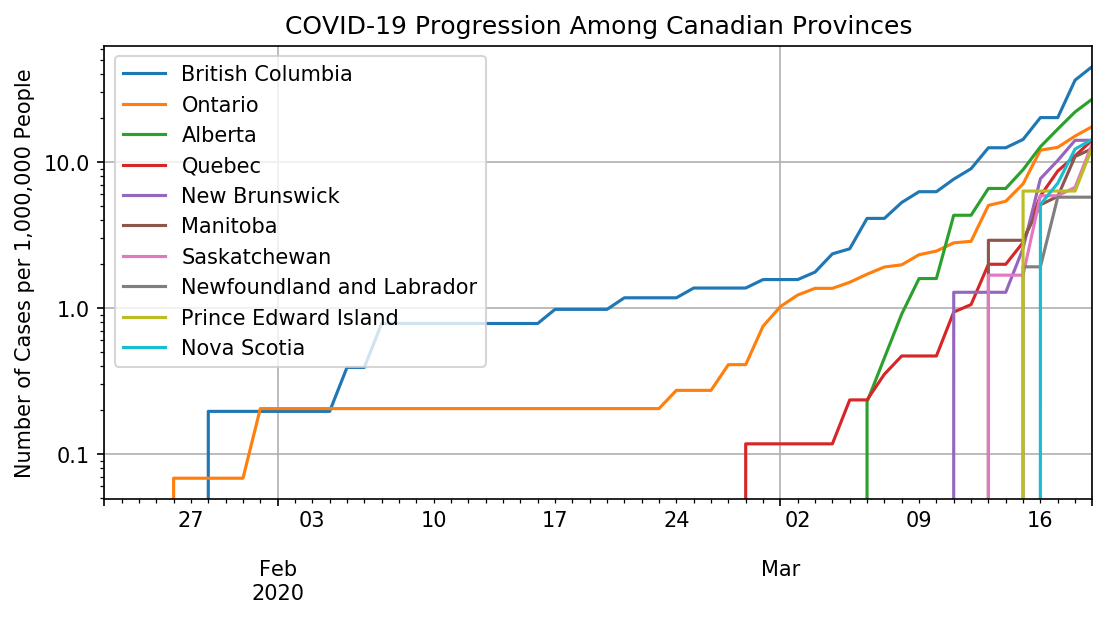

In [20]:
ax = popCanada.plot()
plt.yscale('log')
plt.grid()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
plt.title('COVID-19 Progression Among Canadian Provinces')
plt.ylabel('Number of Cases per 1,000,000 People')
plt.show()

In [21]:
timingCanada  = {}
caseThreshold = 0.3

# first, figure out when they crossed a “magic” threshold
for province in popCanada.columns.values:
    for i in range(len(popCanada[province])):
        if popCanada[province].iloc[i] >= caseThreshold:
            timingCanada[province] = popCanada.index[i]
            break
timingCanada = pd.DataFrame(data=timingCanada, index=['Start of Outbreak']).transpose()
timingCanada

,Start of Outbreak
British Columbia,2020-02-05
Ontario,2020-02-27
Alberta,2020-03-07
Quebec,2020-03-07
New Brunswick,2020-03-11
Manitoba,2020-03-13
Saskatchewan,2020-03-13
Newfoundland and Labrador,2020-03-15
Prince Edward Island,2020-03-15
Nova Scotia,2020-03-16


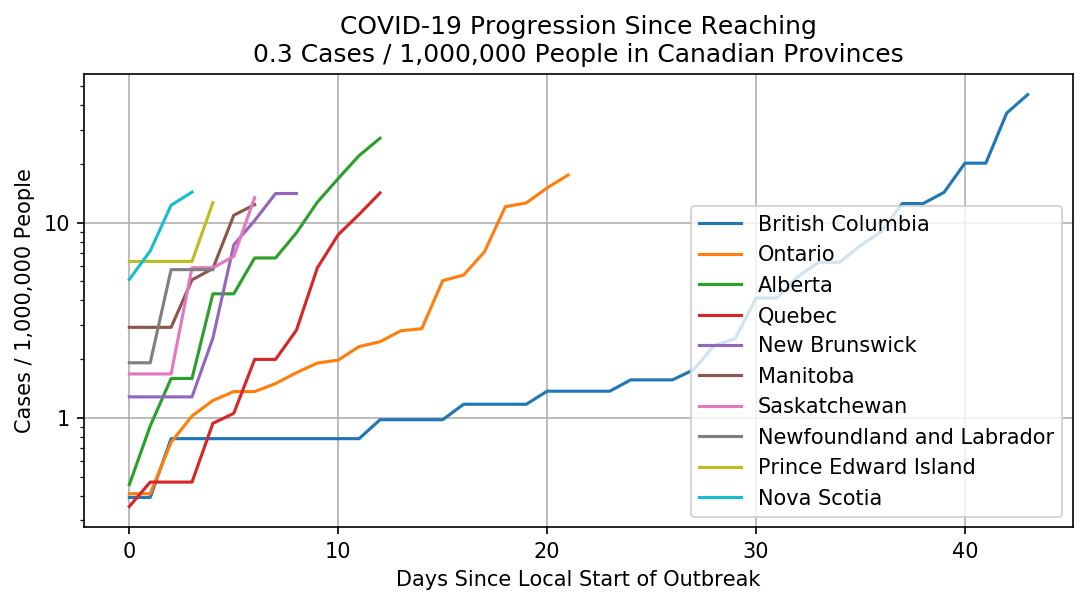

In [22]:
fig, ax = plt.subplots()
plt.yscale('log')

for province, row in timingCanada.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popCanada[province][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    plt.plot(outbreakDays, outbreakCases.values, label=province)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid()
plt.xlabel('Days Since Local Start of Outbreak')
plt.ylabel('Cases / 1,000,000 People')
plt.title('COVID-19 Progression Since Reaching\n%.1f Cases / 1,000,000 People in Canadian Provinces' % caseThreshold)
plt.show()

In [23]:
outbreakRegressionCanada = {
    'slope': [],
    'intercept': [],
    'r2': [],
    'p': [],
    'err': [],
}
for province, row in timingCanada.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popCanada[province][startDate:]
    
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    logCases = np.log10(outbreakCases.values)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(outbreakDays, y=logCases)
    outbreakRegressionCanada['slope'].append(slope)
    outbreakRegressionCanada['intercept'].append(intercept)
    outbreakRegressionCanada['r2'].append(r_value**2)
    outbreakRegressionCanada['p'].append(p_value)
    outbreakRegressionCanada['err'].append(std_err)
    
outbreakRegressionCanada = pd.DataFrame(data=outbreakRegressionCanada, index=timingCanada.index)
outbreakRegressionCanada

,slope,intercept,r2,p,err
British Columbia,0.039057,-0.496801,0.871990,2.334252e-20,0.002309
Ontario,0.071123,-0.337537,0.954303,7.146229e-15,0.003480
Alberta,0.138378,-0.138945,0.962709,3.328066e-09,0.008212
Quebec,0.143292,-0.589885,0.970154,9.745512e-10,0.007578
New Brunswick,0.164568,-0.098705,0.880912,1.781003e-04,0.022870
Manitoba,0.119081,0.356374,0.905825,9.570062e-04,0.017171
Saskatchewan,0.159195,0.118128,0.876775,1.895664e-03,0.026690
Newfoundland and Labrador,0.143136,0.282394,0.750000,5.766889e-02,0.047712
Prince Edward Island,0.060206,0.741409,0.500000,1.816901e-01,0.034760
Nova Scotia,0.157556,0.716219,0.962611,1.887284e-02,0.021957


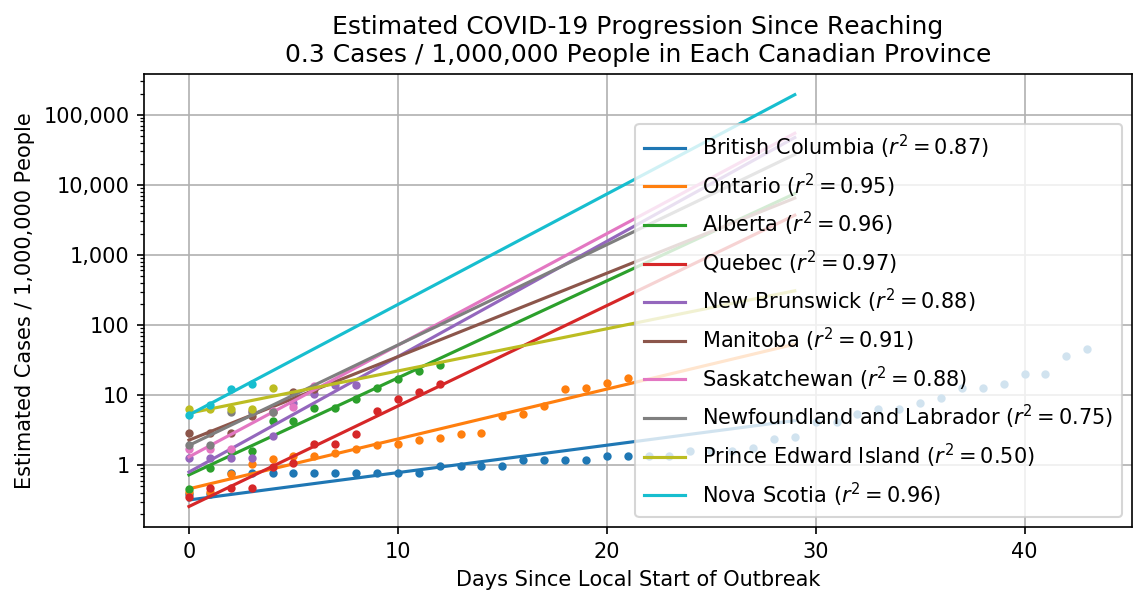

In [24]:
fig, ax = plt.subplots()
plt.yscale('log')

for i, (province, row) in enumerate(timingCanada.iterrows()):
    startDate = row['Start of Outbreak']
    outbreakCases = popCanada[province][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    plt.plot(outbreakDays, outbreakCases.values, '.C%d' % i, label=None)
    plt.plot(np.power(10, np.polyval([outbreakRegressionCanada['slope'][province], outbreakRegressionCanada['intercept'][province]], np.arange(0, 30))), label='%s ($r^2=%.2f$)' % (province, outbreakRegressionCanada['r2'][province]))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid()
plt.xlabel('Days Since Local Start of Outbreak')
plt.ylabel('Estimated Cases / 1,000,000 People')
plt.title('Estimated COVID-19 Progression Since Reaching\n%.1f Cases / 1,000,000 People in Each Canadian Province' % caseThreshold)
plt.show()

In [25]:
datesCanada = {}
for province, row in timingCanada.iterrows():
    startDate = row['Start of Outbreak']
    if outbreakRegressionCanada['slope'][province] == 0:
        continue
    daysTo1In1000 = (np.log10(1_000) - outbreakRegressionCanada['intercept'][province]) / outbreakRegressionCanada['slope'][province]
    if np.isnan(daysTo1In1000):
        continue
    datesCanada[province] = startDate + np.timedelta64(np.int(daysTo1In1000), 'D')
datesCanada = pd.DataFrame(data=datesCanada, index=['Date of 1/1000 Cases'])
datesCanada

,British Columbia,Ontario,Alberta,Quebec,New Brunswick,Manitoba,Saskatchewan,Newfoundland and Labrador,Prince Edward Island,Nova Scotia
Date of 1/1000 Cases,2020-05-04,2020-04-13,2020-03-29,2020-04-01,2020-03-29,2020-04-04,2020-03-31,2020-04-02,2020-04-21,2020-03-30


In [26]:
growthCanada = {}
for province, row in timingCanada.iterrows():
    startDate = row['Start of Outbreak']
    outbreakCases = popCanada[province][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))
    growthRate = np.log(outbreakCases[-1] / outbreakCases[0]) / outbreakDays[-1]
    if growthRate == 0.0 or len(outbreakDays) < 2:
        continue
    doublingTime = np.log(2) / growthRate
    growthCanada[province] = {}
    growthCanada[province]['Growth Rate'] = growthRate
    growthCanada[province]['Doubling Time (Days)'] = doublingTime
growthCanada = pd.DataFrame(data=growthCanada)
growthCanada

,British Columbia,Ontario,Alberta,Quebec,New Brunswick,Manitoba,Saskatchewan,Newfoundland and Labrador,Prince Edward Island,Nova Scotia
Growth Rate,0.110448,0.178920,0.340498,0.308098,0.299737,0.241153,0.346574,0.274653,0.173287,0.343206
Doubling Time (Days),6.275770,3.874066,2.035686,2.249761,2.312519,2.874303,2.000000,2.523719,4.000000,2.019622


In [27]:
provincialGrowthRates = {}
provincialDoublingTimes = {}

# calculate the rates for each province
for province, row in timingCanada.iterrows():
    startDate = timingCanada['Start of Outbreak'][province]
    outbreakCases = popCanada[province][startDate:]
    outbreakDays = list(map(lambda i: (i.timestamp() - outbreakCases.index[0].timestamp()) / (60*60*24), outbreakCases.index))

    growthRate = [0]
    for i in range(1, len(outbreakDays)):
        gr = np.log(outbreakCases[i] / outbreakCases[i - 1])
        growthRate.append(0.5 * (gr - growthRate[i - 1]) + growthRate[i - 1])
    doublingTime = np.log(2) / np.array(growthRate)
    provincialGrowthRates[province] = growthRate
    provincialDoublingTimes[province] = doublingTime

# pad with NaNs so they're all the length
maxLen = 0
index = None
for province in provincialGrowthRates:
    length = len(provincialGrowthRates[province])
    if length > maxLen:
        maxLen = length
        
        startDate = timingCanada['Start of Outbreak'][province]
        outbreakCases = popCanada[province][startDate:]
        index = outbreakCases.index
for province in provincialGrowthRates:
    provincialGrowthRates[province] = np.pad(provincialGrowthRates[province], (maxLen-len(provincialGrowthRates[province]), 0), constant_values=float('NaN'))
    provincialDoublingTimes[province] = np.pad(provincialDoublingTimes[province], (maxLen-len(provincialDoublingTimes[province]), 0), constant_values=float('NaN'))

# make dataframes
provincialGrowthRates = pd.DataFrame(data=provincialGrowthRates, index=index)
provincialDoublingTimes = pd.DataFrame(data=provincialDoublingTimes, index=index)

<ipython-input-27-2adf123e586a>:14: RuntimeWarning: divide by zero encountered in true_divide
  doublingTime = np.log(2) / np.array(growthRate)


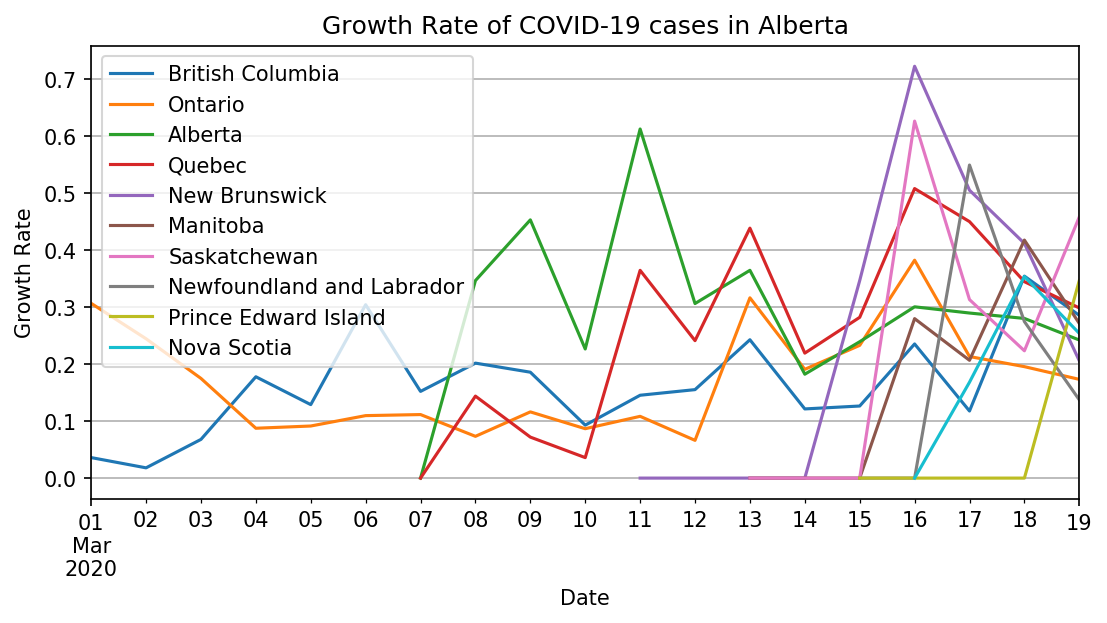

In [28]:
provincialGrowthRates[pd.Timestamp('2020-03-01'):].plot()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.title('Growth Rate of COVID-19 cases in Alberta')
plt.show()

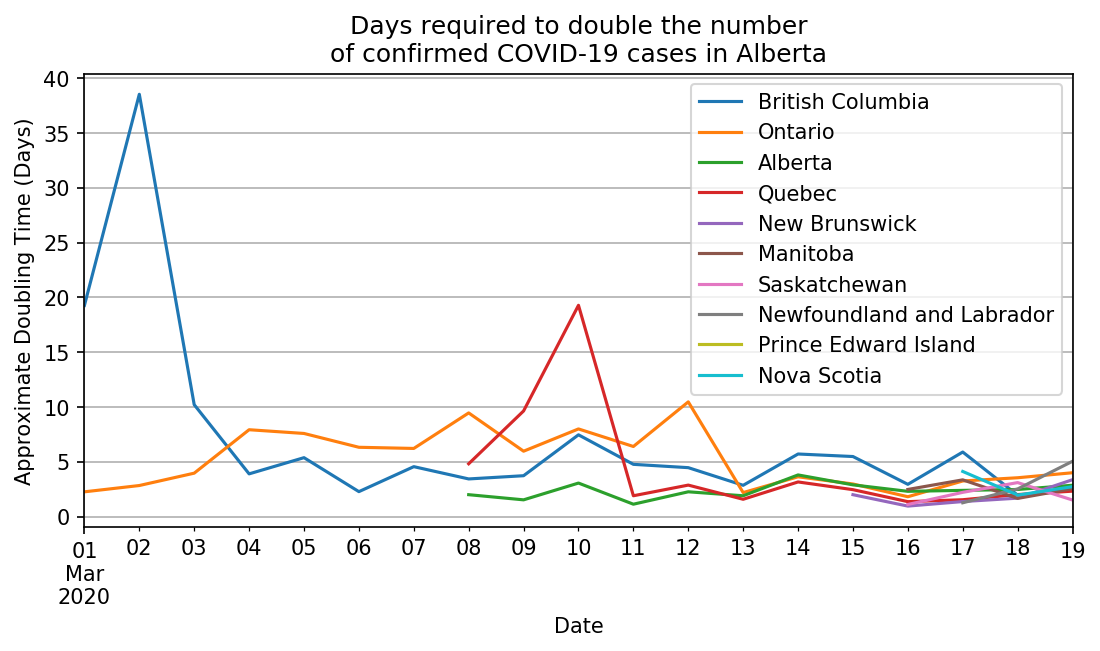

In [29]:
provincialDoublingTimes[pd.Timestamp('2020-03-01'):].plot()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Approximate Doubling Time (Days)')
plt.title('Days required to double the number\nof confirmed COVID-19 cases in Alberta')
plt.show()

## Conclusion

I can't say what this means for sure, and I certainly can't guarantee things will end up looking exactly as forecasted here—it's a forecast, and a pretty naive one at that. But it is troubling, and makes things pretty clear we need to take drastic action sooner rather than later.